# Cluster Analysis - Soft Clustering

In this section we do cluster analysis on taxi data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).
We try to find pattern in the data, identify them and in addition to that we are interested in labeling these cluster patterns.

We are going to do different cluster analysis:

- customer types based on different features
- location based clustering

In general we do a hard and soft clustering, but in this part we perform the soft clustering. The soft clustering we use is the Gaussian Mixture Model.

Our procedure in this part is structured in the following way. For every different cluster analysis we do the following:

- small preprocessing
- deciding for the number of clusters
- process cluster analysis
- analyze und label the clusters

<hr style="border: 1px solid #8888;">

In [16]:
# import all necessary packages
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [17]:
# import datasets
df_chicago = pd.read_csv("data/datasets/df_chicago.csv.zip")

In [18]:
df_chicago_cluster = df_chicago[['start_time_hourly','Trip_Seconds',"Trip_Miles"]]
df_chicago_cluster

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
2,0,1920.0,0.6
3,0,180.0,1.0
4,0,240.0,0.3
...,...,...,...
8974515,23,540.0,1.4
8974516,23,1860.0,5.9
8974517,23,720.0,2.0
8974518,23,660.0,3.5


<hr style="border: 1px solid #8888;">

## Preprocessing

To better interpret and analzye the clusters after processing, we convert the `Trip_Seconds`to `Trip_Minutes`. On the one hand we do this simply because minutes are easier to evaluate and on the other hand because the `Trip_Seconds` are always in 60 second-steps anyway.

In [19]:
df_chicago_cluster['Trip_Minutes'] = df_chicago_cluster['Trip_Seconds']/60
df_chicago_cluster.drop(['Trip_Seconds'], axis = 1,inplace =True)

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_46462/2135727942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_cluster['Trip_Minutes'] = df_chicago_cluster['Trip_Seconds']/60
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_46462/2135727942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_cluster.drop(['Trip_Seconds'], axis = 1,inplace =True)


In [20]:
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['Trip_Miles'] < df_chicago_cluster['Trip_Miles'].quantile(0.95))]
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['Trip_Minutes'] < df_chicago_cluster['Trip_Minutes'].quantile(0.95))]

In [21]:
# Drop unrealistic fast trips
df_chicago_cluster["velocity"] = (df_chicago_cluster["Trip_Miles"]/(df_chicago_cluster["Trip_Minutes"]/60)).round(2)
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['velocity'] < df_chicago_cluster['velocity'].quantile(0.95))]
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['velocity'] > df_chicago_cluster['velocity'].quantile(0.05))]
df_chicago_cluster = df_chicago_cluster.drop(['velocity'], axis = 1)

In [22]:
df_chicago_cluster.reset_index(drop = True)

,start_time_hourly,Trip_Miles,Trip_Minutes
0,0,2.7,15.0
1,0,0.4,4.0
2,0,1.0,3.0
3,0,0.3,4.0
4,0,0.8,8.0
...,...,...,...
7247312,23,0.5,3.0
7247313,23,5.1,19.0
7247314,23,1.4,9.0
7247315,23,2.0,12.0


When researching for the best score to use when deciding which number of cluster to choose for the Gaussian Mixture Model (soft-clustering), we found the Silhouette score and the Bayesian information criterion (BIC).

In [23]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    df_chicago_scaled = scaler.fit_transform(df1)
    df_chicago_scaled = pd.DataFrame(df_chicago_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return df_chicago_scaled

In [24]:
df_cluster_scaled = scaling_data(df_chicago_cluster)

In [25]:
df_cluster_scaled

,start_time_hourly,Trip_Miles,Trip_Minutes
0,-1.983130,0.787302,1.343110
1,-1.983130,-0.970516,-1.242093
3,-1.983130,-0.511955,-1.477111
4,-1.983130,-1.046943,-1.242093
5,-1.983130,-0.664808,-0.302019
...,...,...,...
8974512,1.371088,-0.894089,-1.477111
8974514,1.371088,2.621546,2.283184
8974515,1.371088,-0.206247,-0.067001
8974517,1.371088,0.252314,0.638055


<hr style="border: 1px solid #8888;">

## 1. First Cluster Analysis: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

### 1.1 Decision for number of clusters

### Silhouette score

In [26]:
def silhoutte(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        labels = model_clus.fit_predict(input_data)
        
        clusters.append(k+1)
        scores.append(silhouette_score(input_data, labels = labels, sample_size=1000,random_state=42))
        #defaults: metric=euclidian
        
    return clusters, scores

In [27]:
df_score = df_cluster_scaled.sample(750000, random_state=42)
df_score

,start_time_hourly,Trip_Miles,Trip_Minutes
7859463,-1.983130,-1.123370,0.403036
1567295,-1.983130,-1.046943,0.873073
1532308,-0.670610,-0.511955,-0.537038
8608880,1.225252,-1.215082,-1.477111
1538808,0.350239,-0.817662,-1.242093
...,...,...,...
5094111,-0.670610,-0.129820,-0.772056
1702540,0.496074,-0.741235,-1.477111
7783643,-1.545624,-0.664808,-1.242093
4667153,0.350239,-1.123370,-0.067001


In [28]:
#clusters_sil, scores_sil = silhoutte(df_score, 10)

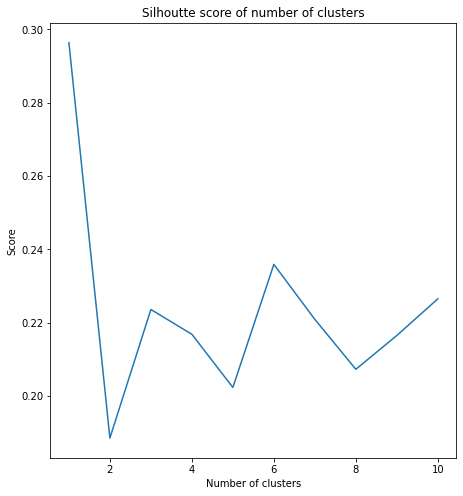

In [61]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score')
plt.show()

### Bayesian information criterion (BIC)

In [30]:
def bic(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        model_clus.fit(input_data)
        
        clusters.append(k+1)
        scores.append(model_clus.bic(input_data))

        #defaults: metric=euclidian
        
    return clusters, scores

In [31]:
#clusters_bic, scores_bic = bic(df_score, 10)

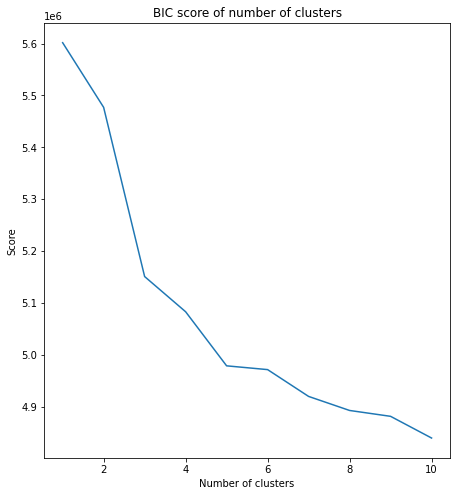

In [59]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score')
plt.show()

### 1.2 Use Gaussian Mixture Model and discover cluster

In [33]:
gm = GaussianMixture(n_components=6, random_state=42, n_init = 15).fit(df_cluster_scaled)

In [34]:
cluster = gm.predict(df_cluster_scaled)

In [35]:
cluster_prob = gm.predict_proba(df_cluster_scaled)

In [36]:
df_chicago_cluster["cluster"] = cluster

In [37]:
for k in range(5):
    df_chicago_cluster[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [38]:
df_chicago_cluster

,start_time_hourly,Trip_Miles,Trip_Minutes,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob
0,0,2.7,15.0,5,9.241915e-05,3.058123e-19,1.994549e-01,5.906753e-31,3.893079e-257
1,0,0.4,4.0,2,1.320698e-02,2.272388e-24,9.855189e-01,4.903452e-29,2.044949e-05
3,0,1.0,3.0,2,8.551338e-02,1.063691e-25,9.128693e-01,5.616273e-32,2.112221e-40
4,0,0.3,4.0,2,7.928040e-03,3.362586e-24,9.853811e-01,7.761108e-29,5.365695e-03
5,0,0.8,8.0,2,7.312054e-03,2.091962e-21,9.536179e-01,5.872735e-28,8.126666e-18
...,...,...,...,...,...,...,...,...,...
8974512,23,0.5,3.0,3,5.465788e-02,8.863715e-03,7.358218e-96,9.348431e-01,1.817717e-10
8974514,23,5.1,19.0,1,9.925098e-18,9.669726e-01,8.885553e-100,6.378516e-10,0.000000e+00
8974515,23,1.4,9.0,0,4.581682e-01,2.344592e-01,4.574040e-99,2.592919e-01,2.035371e-68
8974517,23,2.0,12.0,1,1.090692e-01,7.237247e-01,1.035550e-100,1.630681e-02,6.001451e-141


### 1.3 Analyze and plot the cluster

In [39]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

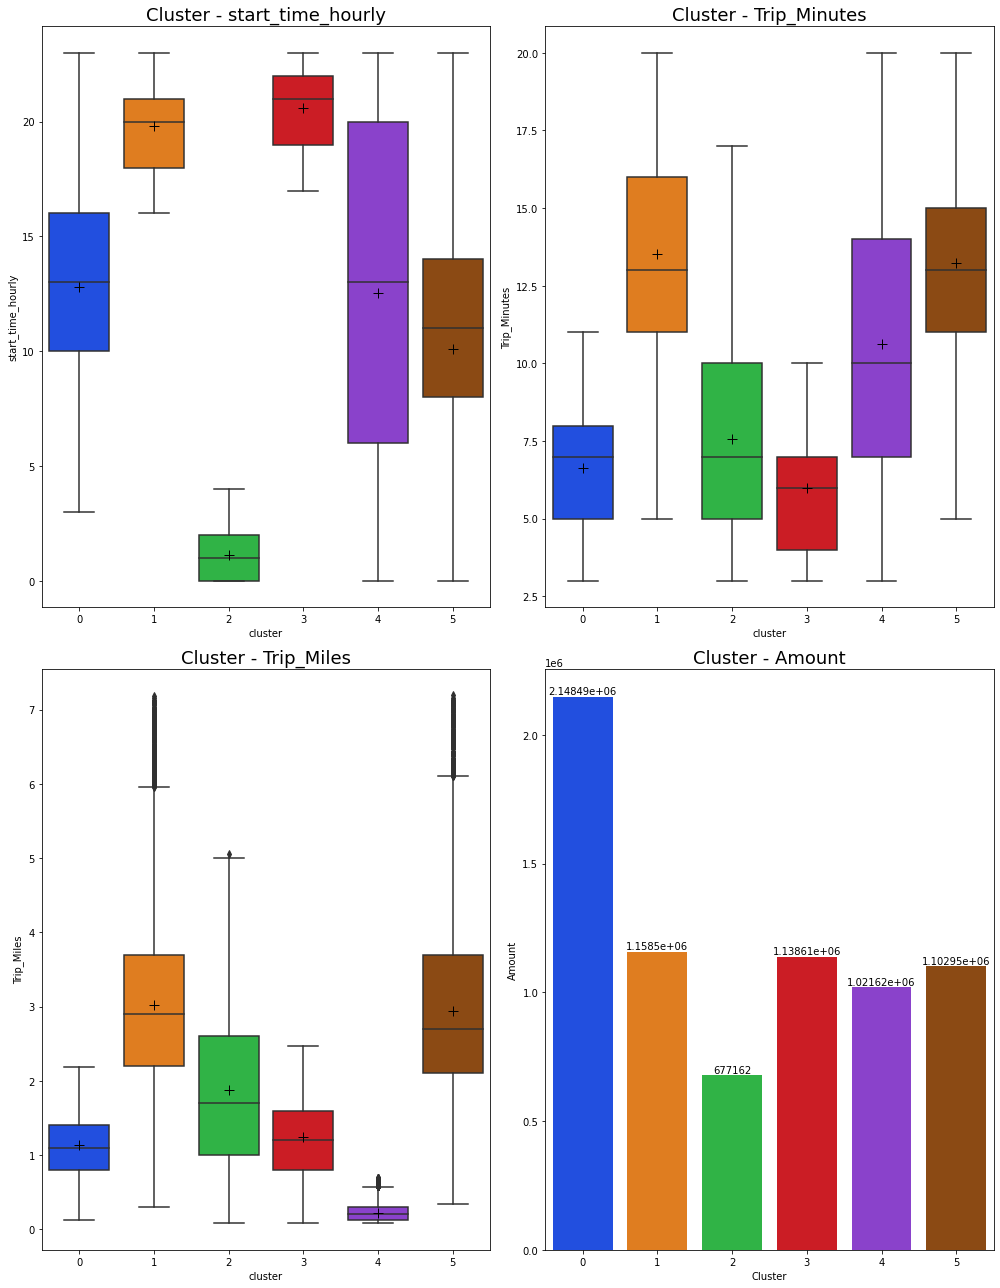

In [41]:
plot_information_about_clusters(df_chicago_cluster, ['start_time_hourly', 'Trip_Minutes', 'Trip_Miles'], 'cluster')

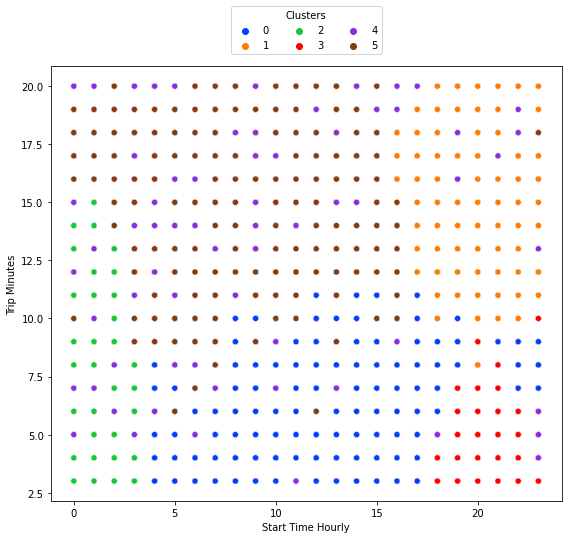

In [53]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Minutes',data=df_chicago_cluster,hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip Minutes')
legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

# Move the legend outside and above the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
# Show the plot
plt.show()

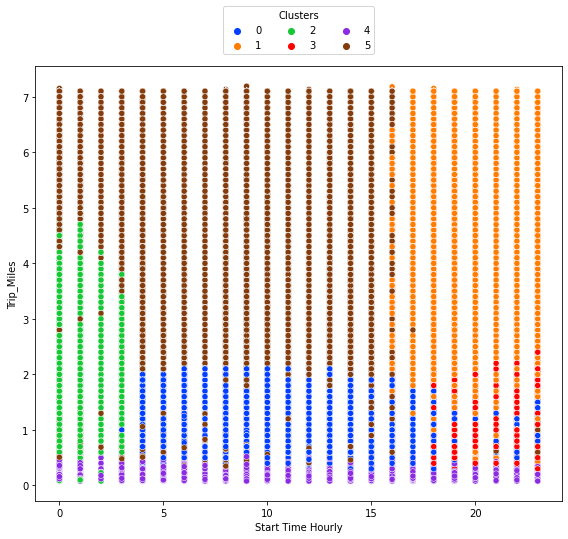

In [45]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Miles', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip_Miles')
legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

# Move the legend outside and above the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
# Show the plot
plt.show()

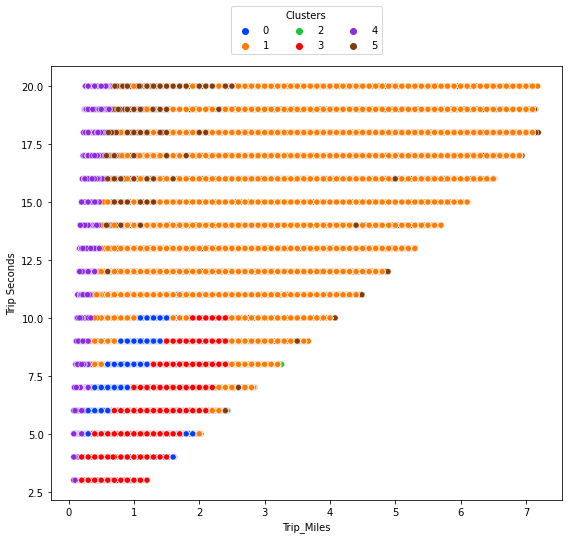

In [47]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='Trip_Miles', y='Trip_Minutes', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Trip_Miles')
plt.ylabel('Trip Seconds')
legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

# Move the legend outside and above the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
# Show the plot
plt.show()

### 1.4 Label and define the cluster

In [65]:
def get_quantiles_of_clusters(n_cluster):
    for cluster in range(0,n_cluster):
        dfchicago_c0 = df_chicago_cluster[df_chicago_cluster['cluster']==cluster]
        print('cluster', cluster)
        print('0,25 - quantile')
        print(dfchicago_c0.quantile(q=0.25))
        print('0,75 - quantile')
        print(dfchicago_c0.quantile(q=0.75),'\n')

In [66]:
get_quantiles_of_clusters(6)

cluster 0
0,25 - quantile
start_time_hourly    1.000000e+01
Trip_Miles           8.000000e-01
Trip_Minutes         5.000000e+00
cluster              0.000000e+00
cluster_0_prob       7.578767e-01
cluster_1_prob       1.255861e-07
cluster_2_prob       3.326120e-45
cluster_3_prob       2.839054e-08
cluster_4_prob       1.517313e-75
Name: 0.25, dtype: float64
0,75 - quantile
start_time_hourly    1.600000e+01
Trip_Miles           1.400000e+00
Trip_Minutes         8.000000e+00
cluster              0.000000e+00
cluster_0_prob       9.817817e-01
cluster_1_prob       5.638528e-03
cluster_2_prob       8.708377e-17
cluster_3_prob       1.992204e-02
cluster_4_prob       6.123602e-23
Name: 0.75, dtype: float64 

cluster 1
0,25 - quantile
start_time_hourly    1.800000e+01
Trip_Miles           2.200000e+00
Trip_Minutes         1.100000e+01
cluster              1.000000e+00
cluster_0_prob       3.854125e-09
cluster_1_prob       6.756721e-01
cluster_2_prob       3.395718e-86
cluster_3_prob       3.985

|   clusters | tripstart-hour   | tripduartion-minutes   | tripdistance-miles   |   trpis (#) | trips (in %)   |
|-----------:|:-----------------|:-----------------------|:---------------------|------------:|:---------------|
|          0 | 10-16            | 5-8                    | 0.8 - 1.2            |      144500 | 26%            |
|          1 | 18-21            | 6-9                    | 0.9 - 1.5            |      133988 | 24%            |
|          2 | 0-2              | 11-15                  | 1.5 - 2.1            |      128096 | 23%            |
|          3 | 19-22            | 18-23                  | 2.5 - 3.4            |       69543 | 13%            |
|          4 | 6-20             | 12-16                  | 2.0 - 2.6            |       77617 | 14%            |
|          4 | 8-14             | 12-16                  | 2.0 - 2.6            |       77617 | 14%            |

In [ ]:
df_chicago['chicago_center'] = [41.881832, -87.623177]

In [ ]:
df_chicago["dist_center_pick"] = df_chicago.apply(lambda row: haversine(row["Pickup_Centroid_Location"], row["end"]), axis=1)
df_chicago["dist_center_drop"] = df_chicago.apply(lambda row: haversine(row["Dropoff_Centroid_Location"], row["end"]), axis=1)
df_chicago[["start", "end", "distance (km)"]]

In [ ]:
df_location = df_chicago['Pickup_Community_Area','Pickup_Centroid_Location',]